In [136]:
import numpy as np
import matplotlib.pyplot as plt
import densityModel as dm
import torch

In [137]:
verbose =True

# initialize
photon_N = 10000
steps_N = 1000
t_delta = 0.001
start_r = 1.5 # in solar radii
start_theta = 0.0 # in rad
start_phi  = 0 # in rad

r_Sun = 6.96e10 # [cm]
c = 2.998e10    # [cm s^(-1)]
c_r=c/r_Sun     # [s^(-1)]

f_ratio  = 3
density_r = dm.saito77 # [cm^(-3)] 
# use saito77 for this calculation 

@torch.enable_grad()
def omega_pe_r(r):
    # Ne with plasma frequency density relationship
    return 8.93e3* (density_r(r))**(0.5) * 2 * np.pi

def v_abs(v): # length of the vector
    # for torch tensor in shape 3*N
    return torch.sqrt(torch.sum(v.pow(2),axis=0))
    

freq0 = f_ratio * omega_pe_r(start_r)/(2*np.pi)

if verbose:
    print('Frequency(MHz) : '+str(freq0/1e6))

rxx = start_r * np.sin(start_theta) * np.cos(start_phi) * np.ones(photon_N)
ryy = start_r * np.sin(start_theta) * np.sin(start_phi) * np.ones(photon_N)
rzz = start_r * np.cos(start_theta) * np.ones(photon_N)
rr = start_r * np.ones(photon_N)
# [r_sun]


Frequency(MHz) : 102.23384391809843


In [138]:

omega0 = freq0*(2*np.pi) # [Hz]
kc0 = np.sqrt(omega0**2. - omega_pe_r(rr)**2.)

k_mu0  = np.random.uniform(low=0 ,high=1,size=photon_N) # k_z > 0
k_phi0 = np.random.uniform(low=0 ,high= 2*np.pi, size=photon_N) # phi in all dir

kc_xx = kc0 * np.sqrt(1-k_mu0**2.) * np.cos(k_phi0)
kc_yy = kc0 * np.sqrt(1-k_mu0**2.) * np.sin(k_phi0)
kc_zz = kc0 * k_mu0

r_vec = torch.tensor(np.array([rxx,ryy,rzz]),requires_grad=True)
kc_vec = torch.tensor(np.array([kc_xx,kc_yy,kc_zz]))

for idx_t in np.arange(steps_N):
    rr = v_abs(r_vec)
    omega_pe_xyz = omega_pe_r(rr).repeat(3,1) # to be size:3*N 
    omega_pe_xyz.backward(r_vec*0+1) # for the gradient of omega
    domega_pe_dxyz = r_vec.grad.data
    
    with torch.no_grad(): # update r and k without grad track
        dr_dt  = c_r / omega0 *kc_vec
        dkc_dt = - omega_pe_xyz/omega0 * domega_pe_dxyz /c_r # maybe wrong not cleared

        r_vec += dr_dt*t_delta
        kc_vec += dkc_dt*t_delta
        
        # to conserve the frequency
        kc_vec = kc_vec * (np.sqrt(omega0**2. - omega_pe_r(rr)**2.) / v_abs(kc_vec)).repeat(3,1)

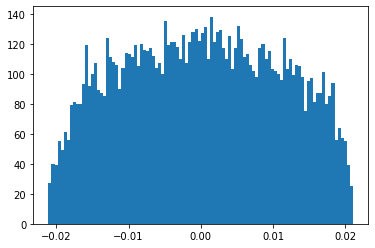

In [139]:
a=plt.hist(r_vec[1,:].detach(),bins=100)

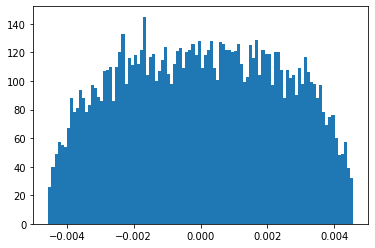

In [143]:
a=plt.hist(dr_dt[0,:].detach(),bins=100)

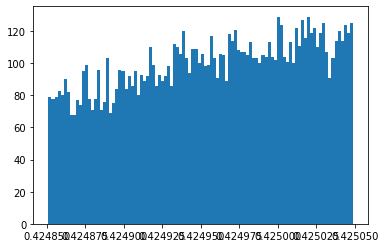

In [141]:
b=plt.hist(v_abs(dr_dt).detach(),100)

In [130]:
((dr_dt[0,:]**2)+(dr_dt[1,:]**2)+(dr_dt[2,:]**2))**0.5

tensor([0.4061, 0.4061, 0.4061,  ..., 0.4061, 0.4061, 0.4062],
       dtype=torch.float64)

In [134]:
dr_dt[2,:]

tensor([0.2688, 0.2798, 0.2160,  ..., 0.3422, 0.3103, 0.3826],
       dtype=torch.float64)

In [15]:
c_r

0.4307471264367816

In [149]:
dkc_dt[2,:]

tensor([2.9993e+11, 3.1066e+11, 3.0775e+11,  ..., 3.0796e+11, 3.0070e+11,
        3.0106e+11], dtype=torch.float64)

In [146]:
kc0

array([6.05617334e+08, 6.05617334e+08, 6.05617334e+08, ...,
       6.05617334e+08, 6.05617334e+08, 6.05617334e+08])